<a href="https://colab.research.google.com/github/676647/ML-aaignment-2/blob/main/GenreDetectorV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSIC GENRE CLASSIFICATION**

https://www.kaggle.com/datasets/thedevastator/spotify-tracks-genre-dataset/data

1. danceability: 0 to 1 values shows how suitable a song is for dancing
2. energy: 0 to 1 intensity and activity
3. key: key of the track, int value
4. loudness: decibles dB of track, float
5. mode: tonal mode of the track > 0 for minor and 1 for major
6. speechiness: 0 to 1, shows presence of spoken words
7. acousticness: 0 to 1, represents the extent to which a track possesses an acoustic quality.
8. instrumentalness: 0 to 1, likelihood of a track being instrumental
9. liveness: 0 to 1, presence of audience during the recording\performance
10. valence: 0 to 1, musical positiveness conveyed
11. tempo: tempo of track in bpm, int
12. time_signature: number of beats within each bar of the track, int
13. genre:

# **1. Setup**

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


Environment setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/GenreDetectorV2'

import os
if not os.path.exists(PATH):
    os.makedirs(PATH)
    os.makedirs(os.path.join(PATH, 'data'))
    os.makedirs(os.path.join(PATH, 'models'))
    print(f"Created in: {PATH}")
else:
    print(f"Path exists: {PATH}")

Path exists: /content/drive/MyDrive/GenreDetectorV2


# **2. Dataset Exploration and Cleaning**

## 2.1 Load and Inspect

In [5]:
import pandas as pd
import numpy as np

DATA_PATH = os.path.join(PATH, 'data', "train.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [7]:
df.shape

(114000, 21)

In [8]:
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [9]:
df.columns
# Unnamed: 0, track_id, artists, album_name, track_name,
# popularity, duration_ms, explicit, danceability,
# energy, key, ,loudness, liveness, valence, tempo, time_signature,
# track_genre

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

## 2.2 EDA

In [10]:
df.isnull().sum()
# not needed to .dropna() since the columns with null values are dropped in a cell further down

,0
Unnamed: 0,0
track_id,0
artists,1
album_name,1
track_name,1
popularity,0
duration_ms,0
explicit,0
danceability,0
energy,0


In [11]:
df.nunique()

,0
Unnamed: 0,114000
track_id,89741
artists,31437
album_name,46589
track_name,73608
popularity,101
duration_ms,50697
explicit,2
danceability,1174
energy,2083


Because of redundant code, especially with rescaling and redoing everything, to shorten the notebook the columns key, time_signature and mode are removed here, but we found out that they were useless after many trial and error runs. Some explanations\reflections will be kept.

In [12]:
df_new = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', "popularity", "explicit", "key", "time_signature", "mode"])
# explicit can help detect hip-hop songs, but other than that it will not be useful, thus dropped
# popularity does not have anything to do with genre of a song
# artists and album names could lead to memorization of pairs : artist:genre; instead of learning the sound


In [13]:
df_new.columns

Index(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'track_genre'],
      dtype='object')

In [14]:
df_new.track_genre.value_counts()

,count
track_genre,
acoustic,1000
afrobeat,1000
alt-rock,1000
alternative,1000
ambient,1000
...,...
techno,1000
trance,1000
trip-hop,1000


In [ ]:
df_new.rename(columns={'track_genre': 'genre'}, inplace=True)

Histogram


Text(0, 0.5, 'Frequency')

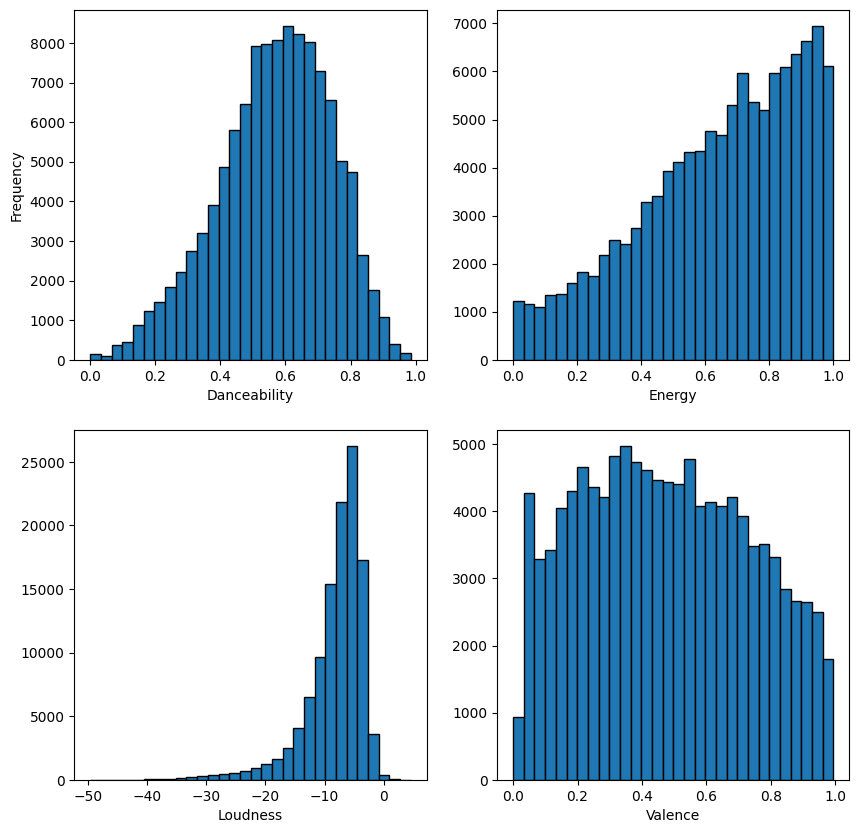

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

axes[0].hist(df_new['danceability'], bins=30, edgecolor='black')
axes[1].hist(df_new['energy'], bins=30, edgecolor='black')
axes[2].hist(df_new['loudness'], bins=30, edgecolor='black')
axes[3].hist(df_new['valence'], bins=30, edgecolor='black')
axes[0].set_xlabel('Danceability')
axes[1].set_xlabel('Energy')
axes[2].set_xlabel('Loudness')
axes[3].set_xlabel('Valence')
axes[0].set_ylabel('Frequency')
# y = frequency
# histogram av danceability energy loudness og valency
#plt.show()

Danceability histogram shows us that most of the songs are songs that one can dance on.


Correlation Matrix

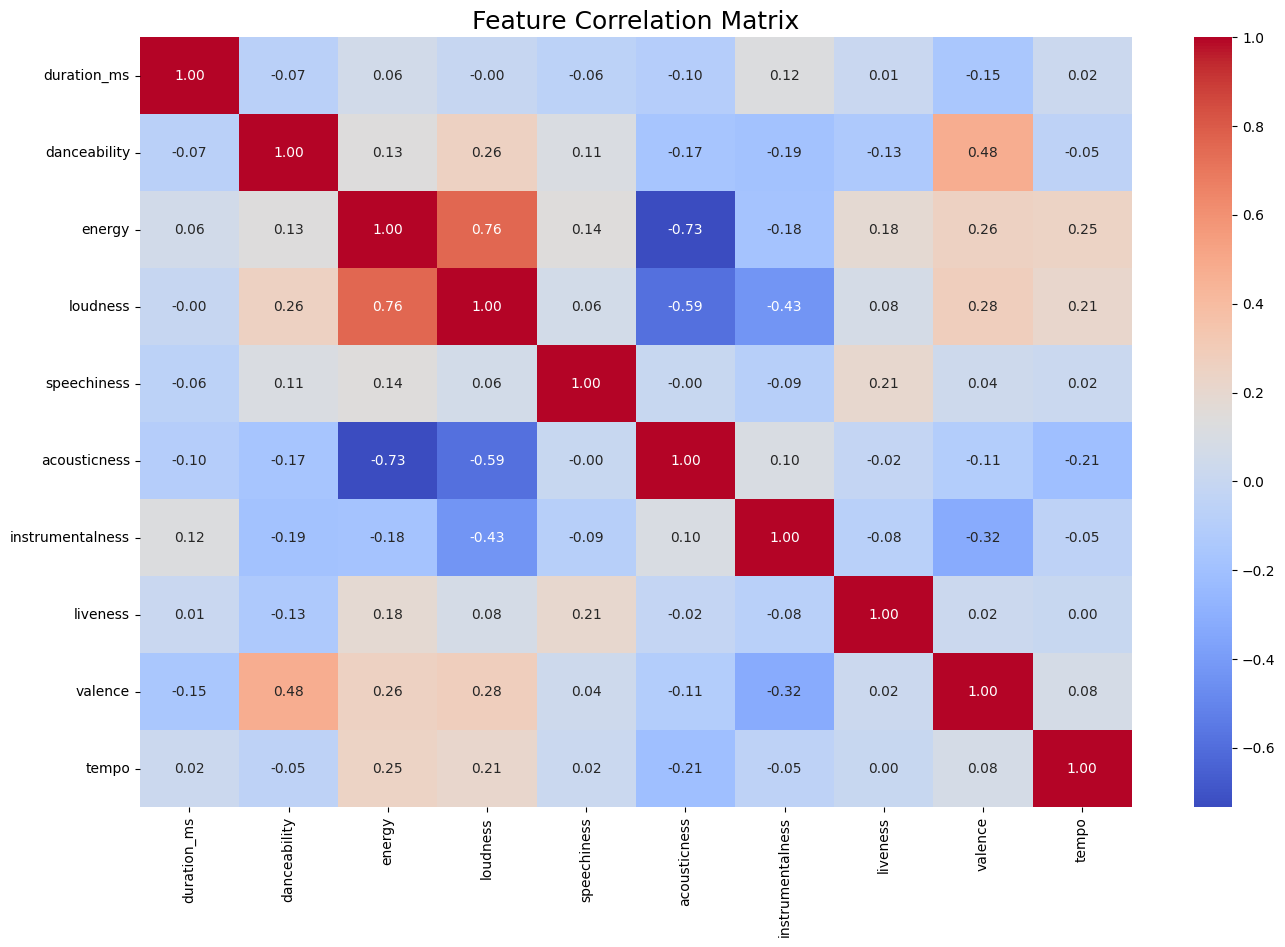

In [16]:
import seaborn as sns

corr = df_new.corr(numeric_only=True)
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix", fontsize=18)
#plt.tight_layout()
plt.show()

high correlation between energy and loudness

high inverse correlation between energy and acousticness

##  2.3 Cleaning and preparation of data

According to chatGPT 114 genres is an overkill for such a project. One should reduce the genres to main genres.

A google search of main music genres gives the following output:
Country, Hip-Hop, Jazz, Rock, Classical music, Electronic, Folk, Soul music, Blues, Latin music, Reggae, Electronic dance music, Funk, Music of Latin America, New-age music, Pop, Pop music, Religious music. Total:18.

We will have to cut them even further, as even commerical systems like Spotify struggle to reliably separate so many genres just from acoustic features.

Selection: Pop, Rock, Hip-Hop, Electronic, RnB, Jazz, Classical, Country, Folk, Reggae

Genres to consider:
1. Metal is a subgenre of rock music
3. Latin contains numerous genres and subgenres, rather than being a single genre itself. Exampleas are salsa, reggaeton, bachata, etc...
4. dance: broad category and a main genre, EDM
5. disco: both main and subgenre of pop
6. house: both main and subgenre of music, EDM
7. punk: both main and subgenre of rock

In [ ]:
sorted(df_new["genre"].unique())

['acoustic',
 'afrobeat',
 'alt-rock',
 'alternative',
 'ambient',
 'anime',
 'black-metal',
 'bluegrass',
 'blues',
 'brazil',
 'breakbeat',
 'british',
 'cantopop',
 'chicago-house',
 'children',
 'chill',
 'classical',
 'club',
 'comedy',
 'country',
 'dance',
 'dancehall',
 'death-metal',
 'deep-house',
 'detroit-techno',
 'disco',
 'disney',
 'drum-and-bass',
 'dub',
 'dubstep',
 'edm',
 'electro',
 'electronic',
 'emo',
 'folk',
 'forro',
 'french',
 'funk',
 'garage',
 'german',
 'gospel',
 'goth',
 'grindcore',
 'groove',
 'grunge',
 'guitar',
 'happy',
 'hard-rock',
 'hardcore',
 'hardstyle',
 'heavy-metal',
 'hip-hop',
 'honky-tonk',
 'house',
 'idm',
 'indian',
 'indie',
 'indie-pop',
 'industrial',
 'iranian',
 'j-dance',
 'j-idol',
 'j-pop',
 'j-rock',
 'jazz',
 'k-pop',
 'kids',
 'latin',
 'latino',
 'malay',
 'mandopop',
 'metal',
 'metalcore',
 'minimal-techno',
 'mpb',
 'new-age',
 'opera',
 'pagode',
 'party',
 'piano',
 'pop',
 'pop-film',
 'power-pop',
 'progressive

1. Keep most of the songs, but merge genres
- con is imbalance of classes, creating biased models. adjust to 1k each main genre with random sample
- synthetically generate small-class samples, con is overfitting
- class_weight=balanced(rf, lr, SVM), still not magic if the class is extremely small
- Hybrid opton: limit the largest classes to be no more than x5 the smallest + class_weight="balanced" + random samples
2. Keep only songs from the chosen genres
3. best of both worlds, accuracy + speed

Delete some genres, rest:
- Merge -> Downsample:
Complex, high-volume genres like rock and electronic, which encompass many subgenres will benefit from having more samples to capture their diversity.



In [ ]:
#Pop, Rock, Hip-Hop, Electronic, RnB,
#Jazz, Classical, Country, Folk, Reggae
genre_grouping = {
    # Pop
    'cantopop': 'pop', 'j-pop': 'pop', 'k-pop': 'pop',
    'pop-film': 'pop', 'pop': 'pop', 'mandopop': 'pop',

    # Rock
    'alt-rock': 'rock', 'alternative': 'rock', 'hard-rock': 'rock',
    'grunge': 'rock', 'metal': 'rock', 'metalcore': 'rock',
    'emo': 'rock', 'punk': 'rock', 'j-rock': 'rock', 'heavy-metal': 'rock',

    #Hip-Hop
    'hip-hop': 'hip-hop',

    #Electronic
    'ambient': 'electronic', 'breakbeat': 'electronic', 'chill': 'electronic',
    'club': 'electronic', 'house': 'electronic', 'techno': 'electronic',
    'edm': 'electronic', 'dubstep': 'electronic', 'trance': 'electronic',

    #RnB
    'r-n-b': 'r-n-b', 'soul': 'r-n-b',

    #Jazz
    'jazz': 'jazz', 'blues': 'jazz',

    #Classical
    'classical': 'classical', 'opera': 'classical', 'tango': 'classical',

    #Country
    'country': 'country', 'honky-tonk': 'country', 'sertanejo': 'country',

    #Folk
    'folk': 'folk', 'acoustic': 'folk', 'singer-songwriter': 'folk',
    'songwriter': 'folk', 'bluegrass': 'folk',

    #Reggae
    'reggae': 'reggae', 'reggaeton': 'reggae', 'dancehall': 'reggae',
    'ska': 'reggae'
}



In [ ]:
original_genres = df_new['genre'].unique()
final_mapping = genre_grouping.copy()
merged_genres = set(genre_grouping.keys())

for genre in original_genres:
    if genre not in merged_genres:
        final_mapping[genre] = "DELETE"
# each genre that is not mapped\grouped will be tagged with DELETE

In [ ]:
# applying the mapping

#apply the final mapping to create the new column called target
df_new["target"] = df_new["genre"].map(final_mapping)

# filter out the rest
df_filtered = df_new[df_new["target"] != "DELETE"].copy()

In [ ]:
df_filtered.drop(columns=["genre"], inplace=True)
#.info()

In [ ]:
df_filtered.reset_index(drop=True, inplace=True)
#.head(-20)

In [ ]:
#downsampling up to 5x 5:1 ratio, REMEMBER hyperparam class_weight="balanced"
genre_counts = df_filtered["target"].value_counts()
# min=1000 ` new max is 5k, previous was 10k
sizeMin = genre_counts.min()
sizeMax = sizeMin * 5

final_samples = []

for genre, count in genre_counts.items():
  genre_data = df_filtered[df_filtered["target"] == genre]

# if a genre has over 5x songs than the genre with the least amount of songs,
# downsample with random sampling,
# else do not touch
  if count > sizeMax:
    # pick random rows but reproducible (seed)
    sampled_data = genre_data.sample(n=sizeMax, random_state=42)
  else:
    sampled_data = genre_data

  final_samples.append(sampled_data)

#combine, ignore_index deals with duplicate index values and reindexes: 0 to N-1
df_final = pd.concat(final_samples, ignore_index=True)


In [ ]:
df_final.shape
#class_weight="balanced"


(35000, 11)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df_final.drop(columns=["target"])
y = df_final["target"]

#test split at 20%
X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42,
# preserve the proportions of classes (important for balancing the 5:1 ratio)
                                                  stratify=y
                                                  )
#validation split which is 25% of the training set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                  test_size=0.25,
                                                  random_state=42,
                                                  stratify=y_temp
                                                  )


In [ ]:
# labels must be encoded to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

## 2.4 Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
# x train, x val, x test
# duration values are in the tens and hundresds of thousands while other features are between 0 and 1
# Models that rely on gradient descent are sensitive to feature magnitude
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. Base Model

We will use LogisticRegression as out base model.

## 3.0 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
base_model = LogisticRegression(
    # Regularization strength, default but can be tweaked later on
    # larger C means less regularization (risk of overfit)
    # small C means more regularization but risk of underfitting
    C = 1.0,
    #default solver is lbfgs, it does not support the L1 penalty, and not all solvers support class weighting well
    # liblinear supports L1 penalty, which can help with feature selection
    solver = "liblinear",
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
base_model.fit(X_train_scaled, y_train_encoded)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42, solver='liblinear')

## 3.1 Feature Importance

In [ ]:
feature_names = X.columns
genre_names = le.classes_
feature_names


Index(['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [ ]:
overall_importance = np.max(np.abs(base_model.coef_), axis=0)
overall_importance

array([0.76385072, 1.30200511, 0.78831826, 0.59123873, 1.05503791,
       1.81912129, 1.34645798, 0.45500528, 0.99319354, 0.20182643])

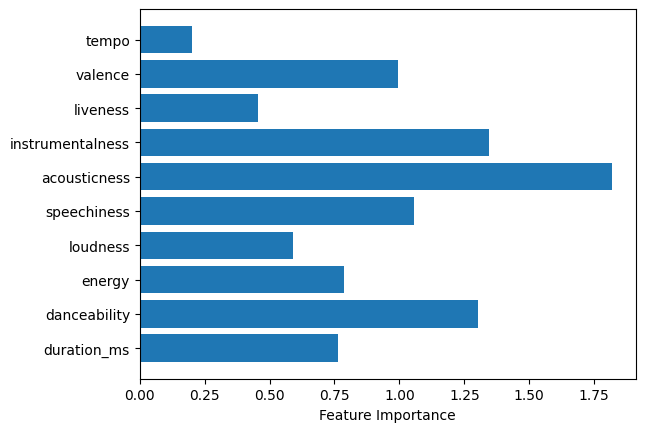

In [ ]:
plt.barh(feature_names, overall_importance)
plt.xlabel("Feature Importance")
plt.show()

Reflection: Keep all features for the next step which will be hyperparameter tuning and more complex models.

The key feature can safely be dropped as its magnitude of 0.06 makes it essentially irrelevant for the decision making process of the model. It will not affect accuracy, it could even be adding noise.

## 3.2 Logistic Regression Evaluation

In [ ]:
from sklearn.metrics import classification_report

y_val_pred_encoded = base_model.predict(X_val_scaled)
#convert encoded predictions and true labels back to genre names for the report
y_val_true_labels = le.inverse_transform(y_val_encoded)
y_val_pred_labels = le.inverse_transform(y_val_pred_encoded)

report = classification_report(y_val_true_labels, y_val_pred_labels)
print("Validation Set Report, 12 features")
print(report)

Validation Set Report, 12 features
              precision    recall  f1-score   support

   classical       0.48      0.70      0.57       600
     country       0.33      0.37      0.35       600
  electronic       0.61      0.41      0.49      1000
        folk       0.37      0.28      0.32      1000
     hip-hop       0.14      0.26      0.18       200
        jazz       0.18      0.14      0.15       400
         pop       0.39      0.27      0.32      1000
       r-n-b       0.18      0.03      0.05       400
      reggae       0.39      0.56      0.46       800
        rock       0.47      0.67      0.55      1000

    accuracy                           0.41      7000
   macro avg       0.35      0.37      0.35      7000
weighted avg       0.40      0.41      0.39      7000



In [ ]:
from sklearn.metrics import roc_auc_score
y_val_proba = base_model.predict_proba(X_val_scaled)
roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')

np.float64(0.8023363518615951)

In [ ]:
# it seems as if the logistic regression base model
# is performing extremely bad,
# with more mistaken than correct classifications

One of the reasons for the low performance of the model could be the way key, time_signature and mode are represented. These three can be disguised as integers, which worsens the prediction performance of the model. The numbers in these features do not have any inherent mathematical relationship to each other.

We saw also that these three features had the lowest feature importance for the models prediction. These could have a much clearer relationship with specific genres, to solve this one can use One-Hot Encode, or drop the columns

In [ ]:
#In this cell the model was retrained, after time_signature and mode were dropped.

The performance of the model remains poor. The scores did not change meaning that these features were indeed not providing any useful information.

It is possible that the data is too complex for the model and is required a non-linear model to unlock the potential.

## 3.3 Overfit or Underfit plt

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

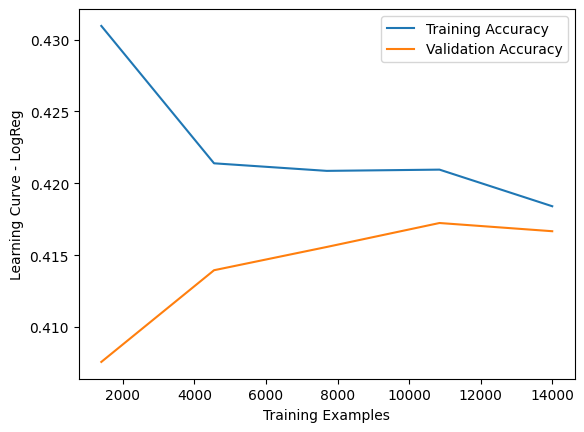

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    base_model,
    X_train_scaled,
    y_train_encoded,
    cv=3,
    scoring="accuracy"
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Examples")
plt.ylabel("Learning Curve - LogReg")
plt.legend()
plt.show()

Interpretation: The model is underfitting. The model is either too simple or the features are not sufficiently discriminvative. It cannot grasp the complexity of genre classification.

Train and validatoin accuracies are close, low variance.

Both accuracies are low, high bias.

The model is too dumb to find strong patterns.

# 4. Advanced Models. Run 1 by 1


1.SVM

2.Random Forest

3.GradientBoostingClassifier: XGBoost, LightGBM



## 4.1 SVM

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    class_weight='balanced',
     probability=True,
    random_state=42,
    max_iter=50000
)

svm_model.fit(X_train_scaled, y_train_encoded)
y_val_pred_encoded = svm_model.predict(X_val_scaled)

y_val_true_labels = le.inverse_transform(y_val_encoded)
y_val_pred_labels = le.inverse_transform(y_val_pred_encoded)

report_svm = classification_report(y_val_true_labels, y_val_pred_labels)

print("Validation Set Report, SVM med rbg kernel")
print(report_svm)


Validation Set Report, SVM med rbg kernel
              precision    recall  f1-score   support

   classical       0.60      0.76      0.67       600
     country       0.46      0.45      0.46       600
  electronic       0.67      0.49      0.57      1000
        folk       0.45      0.38      0.41      1000
     hip-hop       0.16      0.40      0.23       200
        jazz       0.34      0.29      0.31       400
         pop       0.45      0.35      0.39      1000
       r-n-b       0.27      0.30      0.28       400
      reggae       0.47      0.52      0.49       800
        rock       0.57      0.65      0.61      1000

    accuracy                           0.48      7000
   macro avg       0.44      0.46      0.44      7000
weighted avg       0.49      0.48      0.48      7000



In [ ]:
y_val_proba = svm_model.predict_proba(X_val_scaled)
roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')

np.float64(0.8530373366096329)

SVC performed very poorly with 1000 iterations. Accuracy is 48% with 50k iterations. Accuracy more than doubled.

Training it effectively can take multiple hours, but will set aggressive tweaks and tight constraints to get an overview of the model. SVM has time complexity of O(n^2)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform

n_subsample = 8000
train_indices = np.arange(X_train_scaled.shape[0])
subsample_indices = np.random.choice(train_indices, n_subsample, replace=False)
X_train_subsampled = X_train_scaled[subsample_indices]
y_train_subsampled = y_train_encoded[subsample_indices]
param_distributions = {
    'C': loguniform(0.1, 100),
    'gamma': loguniform(0.001, 1),
    'kernel': ['rbf']
}

svm_base = SVC(class_weight='balanced', random_state=42, max_iter=50000)

random_search = RandomizedSearchCV(
    estimator=svm_base,
    param_distributions=param_distributions,
    n_iter=2,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)



In [ ]:
random_search.fit(X_train_scaled, y_train_encoded)
best_svm = random_search.best_estimator_
print("Best Hyperparameters:", best_svm)
y_val_pred_encoded = best_svm.predict(X_val_scaled)

print("-"*30)

y_val_true_labels = le.inverse_transform(y_val_encoded)
y_val_pred_labels = le.inverse_transform(y_val_pred_encoded)

report_best_svm = classification_report(y_val_true_labels, y_val_pred_labels)

print("Validation Set Report, Best SVM")
print(report_best_svm)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Hyperparameters: SVC(C=np.float64(1.3292918943162166), class_weight='balanced',
    gamma=np.float64(0.711447600934342), max_iter=50000, random_state=42)
------------------------------
Validation Set Report, Best SVM
              precision    recall  f1-score   support

   classical       0.67      0.76      0.71       600
     country       0.52      0.55      0.53       600
  electronic       0.61      0.59      0.60      1000
        folk       0.56      0.51      0.53      1000
     hip-hop       0.22      0.38      0.28       200
        jazz       0.47      0.43      0.45       400
         pop       0.50      0.43      0.47      1000
       r-n-b       0.35      0.34      0.34       400
      reggae       0.54      0.55      0.54       800
        rock       0.60      0.62      0.61      1000

    accuracy                           0.54      7000
   macro avg       0.50      0.52      0.51      7000
weighted avg   

A 3 minute search of hyperparams ended up giving a 54% accuracy, which is far from ideal, but it is still a 13% increase from the base model. We will move on with more powerful models

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    best_svm,
    X_train_scaled,
    y_train_encoded,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

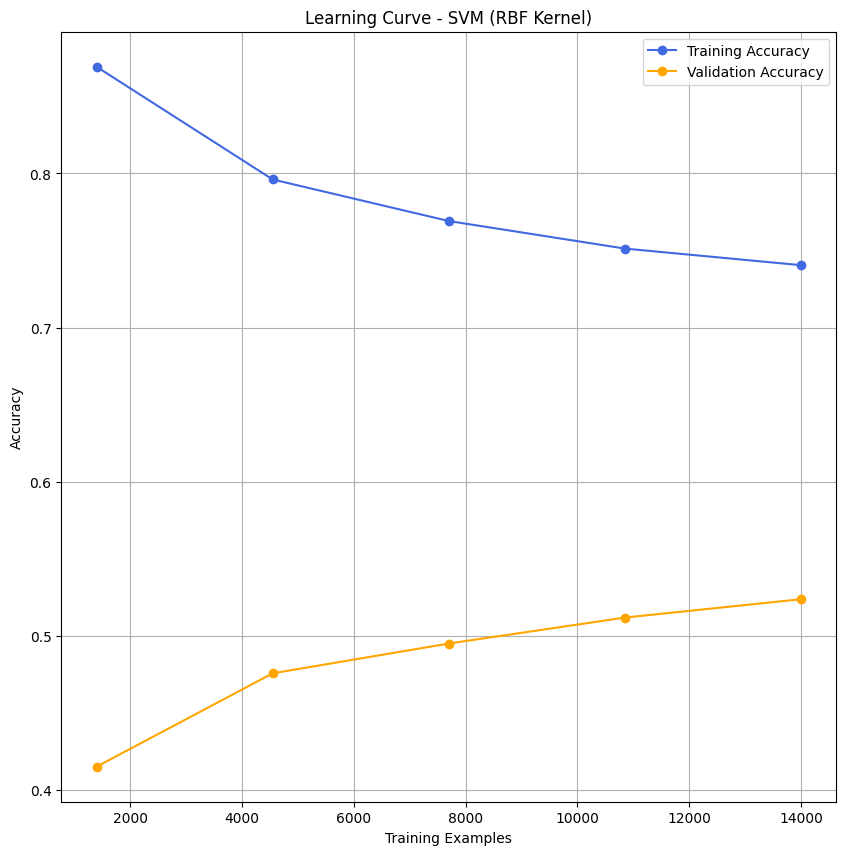

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_mean, 'o-', color='royalblue', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Accuracy')

plt.title("Learning Curve - SVM (RBF Kernel)")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

Huge gap > the model is overfitting the training data patterns and fails to generalize. The reasons for that could be in how "C" and "gamma" were affected.

With standarized data C can be pushed towards 1000 to separate tight clusters.

With scaled features, gamma values above 1 can still matter and 0.001 might be too high for our model because it has many features.


## 4.2 Random Forest Classifier

With nlogn Time Complexity, it can be tuned a lot more, as well as be trained on the entire dataset and provide better results.

Execution time: 9min

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
# 1. set the param list
rf_param_dist = {
    'n_estimators': randint(low=100, high=500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(low=2, high=10),
    'min_samples_leaf': randint(low=1, high=5),
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}
#2.
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

# RF is quick, we can train it on the full dataset with more iterations to get a more reliable tune

rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_dist,
    n_iter=10,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train_scaled, y_train_encoded)
best_rf = rf_random_search.best_estimator_
print("Best Hyperparameters:", best_rf)
print(f'Best cross-validation F1-weighted score: {rf_random_search.best_score_:.4f}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=8, n_estimators=206, random_state=42)
Best cross-validation F1-weighted score: 0.5814


In [ ]:
y_val_pred_encoded = best_rf.predict(X_val_scaled)

print("-"*30)

y_val_true_labels = le.inverse_transform(y_val_encoded)
y_val_pred_labels = le.inverse_transform(y_val_pred_encoded)

report_best_rf = classification_report(y_val_true_labels, y_val_pred_labels)

print("Validation Set Report, Best RF")
print(report_best_rf)

------------------------------
Validation Set Report, Best RF
              precision    recall  f1-score   support

   classical       0.69      0.79      0.74       600
     country       0.62      0.63      0.62       600
  electronic       0.73      0.63      0.67      1000
        folk       0.61      0.65      0.63      1000
     hip-hop       0.39      0.34      0.36       200
        jazz       0.62      0.44      0.51       400
         pop       0.53      0.51      0.52      1000
       r-n-b       0.50      0.39      0.44       400
      reggae       0.55      0.65      0.60       800
        rock       0.63      0.69      0.66      1000

    accuracy                           0.61      7000
   macro avg       0.59      0.57      0.58      7000
weighted avg       0.61      0.61      0.60      7000



In [ ]:
from sklearn.metrics import roc_auc_score
y_val_proba = best_rf.predict_proba(X_val_scaled)
roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')

np.float64(0.8980917748805956)

61% accuracy performance is good baseline for a multi class problem like this one.

n_estimators=206 (speed vs performance), max_depth=30 - deep forest - indication that the data requires complex, non-linear boundaries, min_samples_split=8 - prevents overfitting.

RFC struggled with Hip-Hop. It confuses the genre significantly with other genres. F1 score is 0.36

R-n-b had a low recall at 0.39. It means the model misses these tracks, aka misclassifying them. Same for jazz.

So the classes with the lowest support are the ones performing the worst. Although we are weighting the classes, the model still has trouble learning the minority class patterns effectively.

In [ ]:
# plot learning curve to check for overfitting or underfitting
#
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)



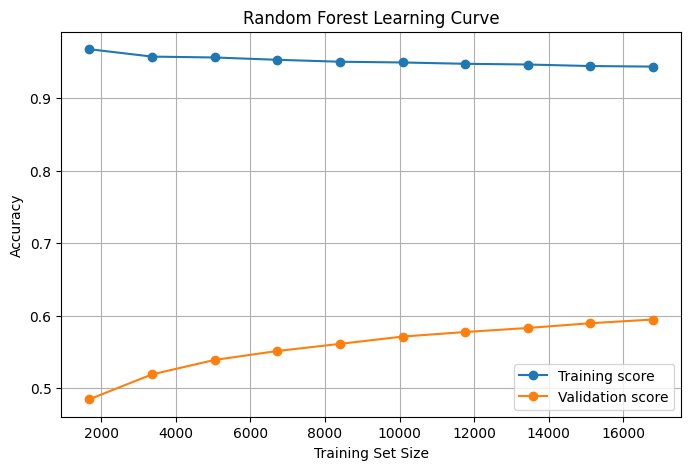

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation score')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Random Forest Learning Curve")
plt.legend()
plt.grid()
plt.show()

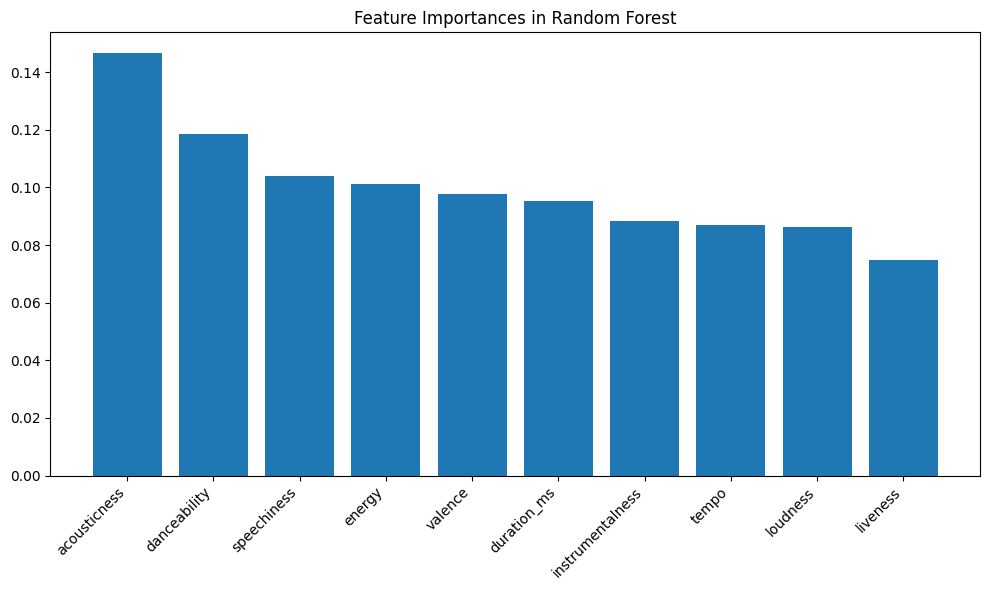

In [ ]:
# feature importance bar plot
# if a few features dominate there is a risk of high variance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices][:15], align='center')
plt.xticks(range(len(importances)), np.array(feature_names)[indices][:15], rotation=45, ha='right')
plt.title("Feature Importances in Random Forest")
plt.tight_layout()
plt.show()

## 4.3 Gradient Boosting

Time to fit the model: 25 minutes

Models like XGBoost and LightGBM build the trees sequentially, correcting the errors of the previous trees. In theory they should be way better at learning complex boundaries. In practice... we are about to find out.

We will use LightGBM since it is faster and more memory-efficient.

Can lead to overfitting, but it can be minimized by defining the depth for splitting.

In [ ]:
from lightgbm import LGBMClassifier

# base estimator
lgbm_base = LGBMClassifier(
    objective='multiclass',
    metric='multi_logloss',
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

# hyperparam search space
lgbm_param_dist = {
    'n_estimators': randint(low=100, high=500),
    'learning_rate': loguniform(0.01, 0.3), # step size at each iteration
    'max_depth': [10,20,30],
    'reg_alpha': loguniform(0.001,10), # l1 regularization
    'reg_lambda': loguniform(0.001,10) # l2
}

#RandomizedSearchCV
lgbm_random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_dist,
    n_iter=15,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)




In [ ]:
lgbm_random_search.fit(X_train_scaled, y_train_encoded)
best_lgbm = lgbm_random_search.best_estimator_
print("Best Hyperparameters:", best_lgbm)
print(f'Best cross-validation F1-weighted score: {lgbm_random_search.best_score_:.4f}')

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 10
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [ ]:
y_val_pred_encoded = best_lgbm.predict(X_val_scaled)

print("-"*30)

y_val_true_labels = le.inverse_transform(y_val_encoded)
y_val_pred_labels = le.inverse_transform(y_val_pred_encoded)

report_best_lgbm = classification_report(y_val_true_labels, y_val_pred_labels)

print("Validation Set Report, Best LGBM")
print(report_best_lgbm)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


------------------------------
Validation Set Report, Best LGBM
              precision    recall  f1-score   support

   classical       0.74      0.77      0.75       600
     country       0.63      0.63      0.63       600
  electronic       0.72      0.64      0.68      1000
        folk       0.60      0.63      0.61      1000
     hip-hop       0.35      0.37      0.36       200
        jazz       0.55      0.47      0.50       400
         pop       0.50      0.51      0.50      1000
       r-n-b       0.45      0.40      0.42       400
      reggae       0.56      0.62      0.59       800
        rock       0.64      0.67      0.65      1000

    accuracy                           0.60      7000
   macro avg       0.57      0.57      0.57      7000
weighted avg       0.60      0.60      0.60      7000



In [ ]:

y_val_proba = best_lgbm.predict_proba(X_val_scaled)
roc_auc_score(y_val, y_val_proba, multi_class='ovr', average='macro')

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


np.float64(0.8925711489940917)

Slightly worse performance than RFC.

# 5. Consider an Ensemble

In [ ]:
proba_preds = {
    "base_model": base_model.predit_proba(X_val_scaled),
    "svm_model": svm_model.predict_proba(X_val_scaled),
    "best_rf": best_rf.predict_proba(X_val_scaled),
    "best_lgbm": best_lgbm.predict_proba(X_val_scaled)
}

AttributeError: 'LogisticRegression' object has no attribute 'predit_proba'

The results were not saved but after attempting a Votingclassifier ensemble it turned out that RFC was best performing alone.

# 6. Gradio

In [ ]:
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined_encoded = np.concatenate((y_train_encoded, y_val_encoded), axis=0)
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

final_params = {
    'n_estimators': 206,
    'max_depth': 30,
    'min_samples_split': 8,
    'random_state': 42
}

final_rf = RandomForestClassifier(n_jobs=-1, **final_params)
final_rf.fit(X_combined_scaled, y_combined_encoded)

joblib.dump(final_rf, 'final_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("SAVED")